## Creating a simple system with the discretizer

In addition to usual imports we need to make and work with a kwant system, we import the discretizer. Since the discretizer takes the symbolic Hamiltonian in the form of a sympy expression, we also need sympy. The momentum operators that we can use in the Hamiltonian are predefined and we also have to import those.

In [1]:
import sys
import os

discretizer_folder ='../'
sys.path.append(os.path.abspath(discretizer_folder))

import scipy.sparse.linalg as sla
import sympy
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')

from discretizer import Discretizer
from discretizer import momentum_operators

try:
    from types import SimpleNamespace
except: # Python 2
    from argparse import Namespace as SimpleNamespace

import kwant
import matplotlib.pyplot as plt
%matplotlib inline

We write the kinetic energy in terms of the imported momentum operators. In addition we add a potential $V$.

In [2]:
kx, ky, kz = momentum_operators
V = sympy.Symbol('V')

H = kx**2 + ky**2 - V
H

       2      2
-V + kₓ  + k_y 

We pass the symbolic Hamiltonian over to the Discretizer and declare that $V$ is space dependend. We do that with the full output. Take a look at the onsite and hopping functions the discretizer created!

In [3]:
tb = Discretizer(H, space_dependent={'V'}, verbose=True)

Discrete coordinates set to:  ['x', 'y']

Function generated for (0, 1):
def _anonymous_func(site1, site2, p):
    (x, y, ) = site2.pos
    return (-1)

Function generated for (1, 0):
def _anonymous_func(site1, site2, p):
    (x, y, ) = site2.pos
    return (-1)

Function generated for (0, 0):
def _anonymous_func(site, p):
    (x, y, ) = site.pos
    V = p.V
    return (4 - V(x, y))



The discretizer can also give these functions in symbolic form, if you want to check them. Then it returns a dictionary where the key is the hopping kind and the entry is the symbolic function. The key of the onsite function is filled with zeroes, so in this case it is $(0, 0)$.

In [4]:
tb.symbolic_hamiltonian

⎧                   4           -1           -1 ⎫
⎪(0, 0): -V(x, y) + ──, (0, 1): ───, (1, 0): ───⎪
⎨                    2            2            2⎬
⎪                   a            a            a ⎪
⎩                                               ⎭

In [5]:
def stadium(position):
    (x, y) = position
    x = max(abs(x) - 20, 0)
    return x**2 + y**2 < 30**2

From the discretizer we get a lattice, the onsite and the hopping functions, so we almost have all we need to make and use the system. We only need to fix the value of $V$. That is why we declare a simple namespace, in which we define $V$ and pass it over as 'args' argument when we call the system's Hamiltonian. Remember that we declared $V$ as space dependend, so we have to make it a function of the position variables $x$ and $y$.

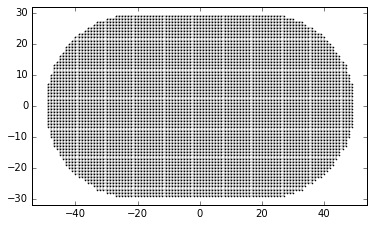

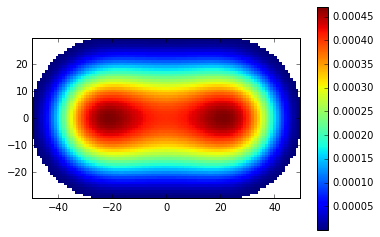

In [6]:
sys = kwant.Builder()
sys[tb.lattice.shape(stadium, (0, 0))] = tb.onsite

for hop, val in tb.hoppings.items():
    sys[hop] = val

sys = sys.finalized()

kwant.plot(sys)
plt.show()

par = SimpleNamespace(V=lambda x, y: 5e-6*(x**2 + y**2))
ham = sys.hamiltonian_submatrix(args=[par], sparse=True)
ev, vec = sla.eigsh(ham, k=10, which='SA')

kwant.plotter.map(sys, abs(vec[:,0])**2)
plt.show()

We could have done the same thing with less code as well. The discretizer's 'build' function can directly make the kwant system for you if you pass it a shape.

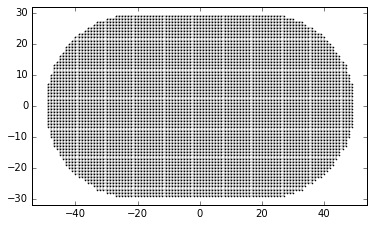

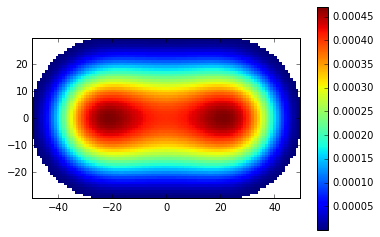

In [7]:
del sys

sys = tb.build(stadium, (0,0))
sys = sys.finalized()

kwant.plot(sys)
plt.show()

par = SimpleNamespace(V=lambda x,y: 5e-6*(x**2 + y**2))
ham = sys.hamiltonian_submatrix(args=[par], sparse=True)
ev, vec = sla.eigsh(ham, k=10, which='SA')

kwant.plotter.map(sys, abs(vec[:,0])**2)
plt.show()